#### This code generates large dataframe containing multiple timeseries

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#### parameters to set

In [18]:
n_series = 6
n_timesteps = 8*24*3600 # 8 days

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

#### generate normal data

In [19]:
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df[s]=pd.Series(v)
df['Flag']=0
#df.head()

#### generate anomalies

In [20]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = (n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    for s in affects:
        df.loc[start:end,s] = df.loc[start:end,s] + random.random() * 0.3
    if len(affects)>1:
        df.loc[start:end,"Flag"]=1
        

#### enforce range

In [21]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

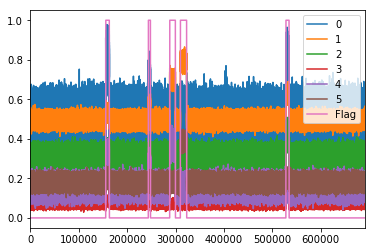

In [22]:
df.plot()

#### running BDT

In [23]:
clf = AdaBoostClassifier(n_estimators=100)
# y=df.Flag
# X=df.loc[:,range(n_series)]
# scores = cross_val_score(clf, X, y)
# print(scores)

#### separate data into Reference and Subject

In [24]:
reference = df[:n_timesteps/4] #df[df.Flag == 0]
X_ref = reference.loc[:, range(n_series)] #separate out the features of the data
y_ref = reference.Flag
subject = df[n_timesteps-3600:] #df[df.Flag == 1]
X_sub = subject.loc[:, range(n_series)]
y_sub = subject.Flag

#### separate Reference and Subject into Train and Test

In [25]:
refTrainSize = reference.shape[0] * 0.7
X_ref_train = X_ref.loc[:refTrainSize, range(n_series)]
X_ref_test  = X_ref.loc[refTrainSize:, range(n_series)]
y_ref_train = y_ref.loc[:refTrainSize]
y_ref_test  = y_ref.loc[refTrainSize:]

subTrainSize = subject.shape[0] * 0.7
X_sub_train = subject.loc[:subTrainSize, range(n_series)]
X_sub_test  = subject.loc[subTrainSize:, range(n_series)]
y_sub_train = y_sub.loc[:subTrainSize]
y_sub_test  = y_sub.loc[subTrainSize:]

#### Combine reference and subject train and test datasets

In [26]:
X_train_frames = [X_ref_train, X_sub_train]
X_train = pd.concat(X_train_frames)
y_train_frames = [y_ref_train, y_sub_train]
y_train = pd.concat(y_train_frames)

X_test_frames = [X_ref_test, X_sub_test]
X_test = pd.concat(X_test_frames)
y_test_frames = [y_ref_test, y_sub_test]
y_test = pd.concat(y_test_frames)

#### Train model using the combined train data

In [27]:
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

#### Predict using the combined test data

In [28]:
y_predict = clf.predict(X_test)

#### Calculate AUC

In [29]:
from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

# convert False and True to 0 and 1
#lb = LabelBinarizer()
#y_test_transformed = lb.fit_transform(y_test)
#y_predict_transformed = lb.fit_transform(y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
auc_score = auc(fpr, tpr)
print auc_score

0.5


#### Graph

In [30]:
def Adaboost(X_Train,X_Test,y_Train, y_Test):
    clf = AdaBoostClassifier(n_estimators=100)
    #creates a boosted decision tree
    #scores = cross_val_score(clf, iris.data, iris.target)
    #scores.mean()  
    clf.fit(X_Train,y_Train)
    #trains the model
    
    y_predict = clf.predict(X_Test)
    
#    lb = LabelBinarizer()
#    y_test_transformed = lb.fit_transform(y_Test)
#    y_predict_transformed = lb.fit_transform(y_predict)

    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    return clf

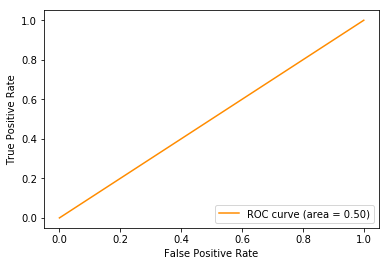

In [31]:
clf=Adaboost(X_train, X_test, y_train, y_test)

#### Predicted Flags over the Testing Features

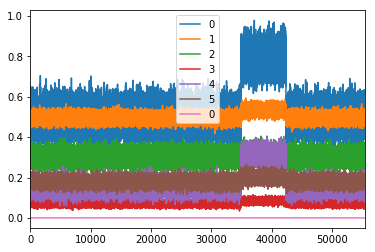

In [32]:
y_predict_df = pd.DataFrame(y_predict)
X_test_reset_index = X_test.reset_index(drop=1) #Reindex
x_y_combined = pd.concat([X_test_reset_index, y_predict_df], axis=1)
x_y_combined.plot()